# Create, evaluate, and score a churn prediction model

## Introduction

In this notebook, you'll see a Microsoft Fabric data science workflow with an end-to-end example. The scenario is to build a model to predict whether bank customers would churn or not. The churn rate, also known as the rate of attrition refers to the rate at which bank customers stop doing business with the bank.

The main steps in this notebook are:

1. Install custom libraries
2. Load the data
3. Understand and process the data through exploratory data analysis and demonstrate the use of Fabric Data Wrangler feature
4. Train machine learning models using `Scikit-Learn` and `LightGBM`, and track experiments using MLflow and Fabric Autologging feature
5. Evaluate and save the final machine learning model
6. Demonstrate the model performance via visualizations in Power BI


## Prerequisites
- [Add a lakehouse](https://aka.ms/fabric/addlakehouse) to this notebook. You will be downloading data from a public blob, then storing the data in the lakehouse. 

## Step 1: Install custom libraries


When developing a machine learning model or doing ad-hoc data analysis, you may need to quickly install a custom library (e.g., `imblearn` in this notebook) for the Apache Spark session. To do this, you have two choices. 

1. You can use the in-line installation capabilities (e.g., `%pip`, `%conda`, etc.) to quickly get started with new libraries. Note that this installation option would install the custom libraries only in the current notebook and not in the workspace.

```python
# Use pip to install libraries
%pip install <library name>

# Use conda to install libraries
%conda install <library name>
 
```
2. Alternatively, you can follow the instructions [here](https://aka.ms/fabric/create-environment) to learn how to create an environment which allows you to install libraries from public sources or upload custom libraries built by you or your organization.

For this notebook, you'll install the `imblearn` using `%pip install`. Note that the PySpark kernel will be restarted after `%pip install`, thus you'll need to install the library before you run any other cells.

In [1]:
# Use pip to install imblearn for SMOTE
%pip install imblearn

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 8, Finished, Available)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 9.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Step 2: Load the data

### Dataset

The dataset contains churn status of 10,000 customers along with 14 attributes that include credit score, geographical location (Germany, France, Spain), gender (male, female), age, tenure (years of being bank's customer), account balance, estimated salary, number of products that a customer has purchased through the bank, credit card status (whether a customer has a credit card or not), and active member status (whether an active bank's customer or not).

The dataset also includes columns such as row number, customer ID, and customer surname that should have no impact on customer's decision to leave the bank. The event that defines the customer's churn is the closing of the customer's bank account, therefore, the column `exit` in the dataset refers to customer's abandonment. Since you don't have much context about these attributes, you'll proceed without having background information about the dataset. Your aim is to understand how these attributes contribute to the `exit` status.

Out of the 10,000 customers, only 2037 customers (around 20%) have left the bank. Therefore, given the class imbalance ratio, it is recommended to generate synthetic data.

- churn.csv

|"CustomerID"|"Surname"|"CreditScore"|"Geography"|"Gender"|"Age"|"Tenure"|"Balance"|"NumOfProducts"|"HasCrCard"|"IsActiveMember"|"EstimatedSalary"|"Exited"|
|---|---|---|---|---|---|---|---|---|---|---|---|---|
|15634602|Hargrave|619|France|Female|42|2|0.00|1|1|1|101348.88|1|
|15647311|Hill|608|Spain|Female|41|1|83807.86|1|0|1|112542.58|0|




### Introduction to SMOTE

The problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary. Synthetic Minority Oversampling Technique (SMOTE) is the most widely used approach to synthesize new samples for the minority class. Learn more about SMOTE [here](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html#) and [here](https://imbalanced-learn.org/stable/over_sampling.html#smote-adasyn).

You will be able to access SMOTE using the `imblearn` library that you installed in Step 1.

### Download dataset and upload to lakehouse

> [!TIP]
> By defining the following parameters, you can use this notebook with different datasets easily.


In [2]:
IS_CUSTOM_DATA = False  # if TRUE, dataset has to be uploaded manually

IS_SAMPLE = False  # if TRUE, use only SAMPLE_ROWS of data for training, otherwise use all data
SAMPLE_ROWS = 5000  # if IS_SAMPLE is True, use only this number of rows for training

DATA_ROOT = "/lakehouse/default"
DATA_FOLDER = "Files/churn"  # folder with data files
DATA_FILE = "churn.csv"  # data file name

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 10, Finished, Available)



This code downloads a publicly available version of the dataset and then stores it in a Fabric lakehouse.

> [!IMPORTANT]
> **Make sure you [add a lakehouse](https://aka.ms/fabric/addlakehouse) to the notebook before running it. Failure to do so will result in an error.**

In [3]:
import os, requests
if not IS_CUSTOM_DATA:
# Using synapse blob, this can be done in one line

# Download demo data files into lakehouse if not exist
    remote_url = "https://synapseaisolutionsa.blob.core.windows.net/public/bankcustomerchurn"
    file_list = ["churn.csv"]
    download_path = "/lakehouse/default/Files/churn/raw"

    if not os.path.exists("/lakehouse/default"):
        raise FileNotFoundError(
            "Default lakehouse not found, please add a lakehouse and restart the session."
        )
    os.makedirs(download_path, exist_ok=True)
    for fname in file_list:
        if not os.path.exists(f"{download_path}/{fname}"):
            r = requests.get(f"{remote_url}/{fname}", timeout=30)
            with open(f"{download_path}/{fname}", "wb") as f:
                f.write(r.content)
    print("Downloaded demo data files into lakehouse.")

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 11, Finished, Available)

Downloaded demo data files into lakehouse.


Start recording the time it takes to run this notebook.

In [4]:
# Record the notebook running time
import time

ts = time.time()

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 12, Finished, Available)

### Read raw data from the lakehouse

Reads raw data from the **Files** section of the lakehouse, adds additional columns for different date parts and the same information will be used to create partitioned delta table.

In [5]:
df = (
    spark.read.option("header", True)
    .option("inferSchema", True)
    .csv("Files/churn/raw/churn.csv")
    .cache()
)

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 13, Finished, Available)

### Create a pandas dataframe from the dataset

This code converts the spark DataFrame to pandas DataFrame for easier processing and visualization.

In [6]:
df = df.toPandas()

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 14, Finished, Available)

## Step 3: Exploratory Data Analysis

### Display raw data

Explore the raw data with `display`, do some basic statistics and show chart views. You first need to import required libraries for data visualization such as `seaborn` which is a Python data visualization library to provide a high-level interface for building visuals on dataframes and arrays. Learn more about [`seaborn`](https://seaborn.pydata.org/). 

In [7]:
import seaborn as sns
sns.set_theme(style="whitegrid", palette="tab10", rc = {'figure.figsize':(9,6)})
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib import rc, rcParams
import numpy as np
import pandas as pd
import itertools

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 15, Finished, Available)

In [8]:
display(df, summary=True)

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 16, Finished, Available)

SynapseWidget(Synapse.DataFrame, db75efed-9058-4c32-882b-d28ffc3190ec)

### Use Data Wrangler to perform initial data cleansing

Launch Data Wrangler directly from the notebook to explore and transform any pandas dataframe. Under the notebook ribbon `Data` tab, you can use the Data Wrangler dropdown prompt to browse the activated pandas DataFrames available for editing and select the one you wish to open in Data Wrangler. 

>[!NOTE]
>Data Wrangler can not be opened while the notebook kernel is busy. The cell execution must complete prior to launching Data Wrangler. [Learn more about Data Wrangler](https://aka.ms/fabric/datawrangler).

<br>

<img src="https://sdkstorerta.blob.core.windows.net/churnblob/select_datawrangler.png"  width="40%" height="10%" title="Screenshot shows where to access the Data Wrangler.">

Once the Data Wrangler is launched, a descriptive overview of the displayed data panel is generated as shown in the following images. It includes information about the DataFrame's dimension, missing values, etc. You can then use Data Wrangler to generate the script for dropping the rows with missing values, the duplicate rows and the columns with specific names, then copy the script into a cell.  The next cell shows that copied script.


<img style="float: left;" src="https://sdkstorerta.blob.core.windows.net/churnblob/menu_datawrangler.png"  width="45%" height="10%" title="Screenshot shows Data Wrangler menu."> 
<img style="float: left;" src="https://sdkstorerta.blob.core.windows.net/churnblob/missing_data_datawrangler.png"  width="45%" height="10%" title="Screenshot shows Data Wrangler missing data display.">



In [9]:
def clean_data(df):
    # Drop rows with missing data across all columns
    df.dropna(inplace=True)
    # Drop duplicate rows in columns: 'RowNumber', 'CustomerId'
    df.drop_duplicates(subset=['RowNumber', 'CustomerId'], inplace=True)
    # Drop columns: 'RowNumber', 'CustomerId', 'Surname'
    df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)
    return df

df_clean = clean_data(df.copy())

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 17, Finished, Available)

In [10]:
# if IS_SAMPLE is True, use only SAMPLE_ROWS of rows for training
if IS_SAMPLE:
    df_clean = df_clean.limit(SAMPLE_ROWS)

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 18, Finished, Available)

##### Determine attributes

Use this code to determine categorical, numerical, and target attributes.

In [11]:
# Determine the dependent (target) attribute
dependent_variable_name = "Exited"
print(dependent_variable_name)
# Determine the categorical attributes
categorical_variables = [col for col in df_clean.columns if col in "O"
                        or df_clean[col].nunique() <=5
                        and col not in "Exited"]
print(categorical_variables)
# Determine the numerical attributes
numeric_variables = [col for col in df_clean.columns if df_clean[col].dtype != "object"
                        and df_clean[col].nunique() >5]
print(numeric_variables)

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 19, Finished, Available)

Exited
['Geography', 'Gender', 'NumOfProducts', 'HasCrCard', 'IsActiveMember']
['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']



##### The five-number summary 

Show the five-number summary (the minimum score, first quartile, median, third quartile, the maximum score) for the numerical attributes, using box plots.

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 20, Finished, Available)

/tmp/ipykernel_21495/2095287195.py:4: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


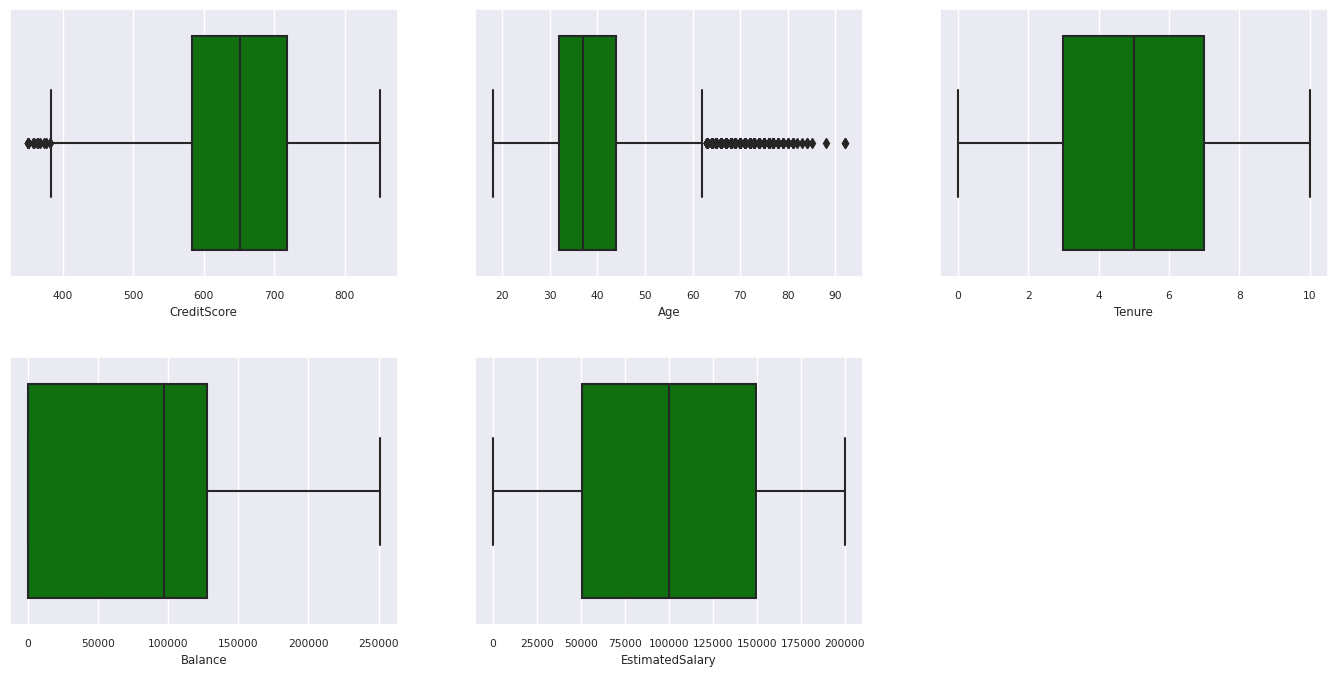

In [12]:
df_num_cols = df_clean[numeric_variables]
sns.set(font_scale = 0.7) 
fig, axes = plt.subplots(nrows = 2, ncols = 3, gridspec_kw =  dict(hspace=0.3), figsize = (17,8))
fig.tight_layout()
for ax,col in zip(axes.flatten(), df_num_cols.columns):
    sns.boxplot(x = df_num_cols[col], color='green', ax = ax)
# fig.suptitle('visualize and compare the distribution and central tendency of numerical attributes', color = 'k', fontsize = 12)
fig.delaxes(axes[1,2])


##### Distribution of exited and non-exited customers 

Show the distribution of exited versus non-exited customers across the categorical attributes.

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 21, Finished, Available)

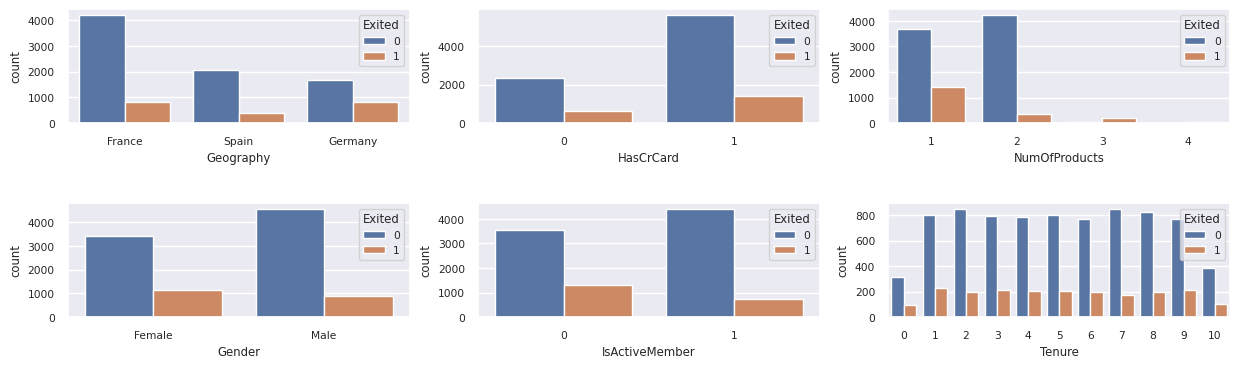

In [13]:
attr_list = ['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'NumOfProducts', 'Tenure']
fig, axarr = plt.subplots(2, 3, figsize=(15, 4))
for ind, item in enumerate (attr_list):
    sns.countplot(x = item, hue = 'Exited', data = df_clean, ax = axarr[ind%2][ind//2])
fig.subplots_adjust(hspace=0.7)

##### Distribution of numerical attributes

Show the the frequency distribution of numerical attributes using histogram.


StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 22, Finished, Available)

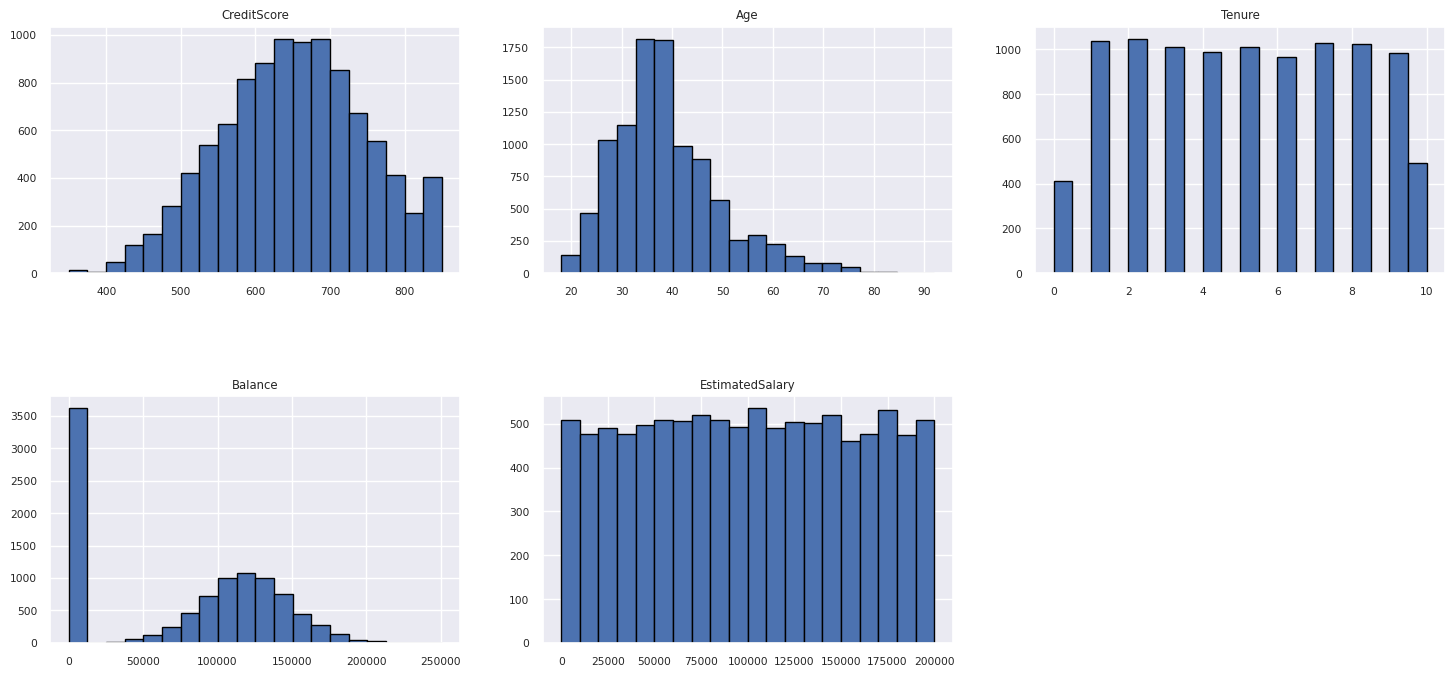

In [14]:
columns = df_num_cols.columns[: len(df_num_cols.columns)]
fig = plt.figure()
fig.set_size_inches(18, 8)
length = len(columns)
for i,j in itertools.zip_longest(columns, range(length)):
    plt.subplot((length // 2), 3, j+1)
    plt.subplots_adjust(wspace = 0.2, hspace = 0.5)
    df_num_cols[i].hist(bins = 20, edgecolor = 'black')
    plt.title(i)
# fig = fig.suptitle('distribution of numerical attributes', color = 'r' ,fontsize = 14)
plt.show()

### Perform feature engineering 

The following feature engineering generates new attributes based on current attributes.

In [15]:
df_clean["NewTenure"] = df_clean["Tenure"]/df_clean["Age"]
df_clean["NewCreditsScore"] = pd.qcut(df_clean['CreditScore'], 6, labels = [1, 2, 3, 4, 5, 6])
df_clean["NewAgeScore"] = pd.qcut(df_clean['Age'], 8, labels = [1, 2, 3, 4, 5, 6, 7, 8])
df_clean["NewBalanceScore"] = pd.qcut(df_clean['Balance'].rank(method="first"), 5, labels = [1, 2, 3, 4, 5])
df_clean["NewEstSalaryScore"] = pd.qcut(df_clean['EstimatedSalary'], 10, labels = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 23, Finished, Available)

### Use Data Wrangler to perform one-hot encoding

Following the same instructions discussed earlier to launch Data Wrangler, use the Data Wrangler to perform one-hot encoding. The next cell shows the copied  generated script for one-hot encoding.

<br>

<img style="float: left;" src="https://sdkstorerta.blob.core.windows.net/churnblob/1hotencoding_data_wrangler.png"  width="45%" height="20%" title="Screenshot shows one-hot encoding in the Data Wrangler"> 
<img style="float: left;" src="https://sdkstorerta.blob.core.windows.net/churnblob/1hotencoding_selectcolumns_data_wrangler.png"  width="45%" height="20%" title="Screenshot shows selection of columns in the Data Wrangler.">





In [16]:
df_clean = pd.get_dummies(df_clean, columns=['Geography', 'Gender'])

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 24, Finished, Available)

### Create a delta table to generate the Power BI report

In [17]:
table_name = "df_clean"
# Create PySpark DataFrame from Pandas
sparkDF=spark.createDataFrame(df_clean) 
sparkDF.write.mode("overwrite").format("delta").save(f"Tables/{table_name}")
print(f"Spark dataframe saved to delta table: {table_name}")

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 25, Finished, Available)

Spark dataframe saved to delta table: df_clean


### Summary of observations from the exploratory data analysis

- Most of the customers are from France comparing to Spain and Germany, while Spain has the lower churn rate comparing to France and Germany.
- Most of the customers have credit cards.
- There are customers whose age and credit score are above 60 and below 400, respectively, but they can't be considered as outliers.
- Very few customers have more than two of the bank's products.
- Customers who aren't active have a higher churn rate.
- Gender and tenure years don't seem to have an impact on customer's decision to close the bank account.

## Step 4: Model training and tracking


With your data in place, you can now define the model. You'll apply Random Forrest and LightGBM models in this notebook. 

Use `scikit-learn` and `lightgbm` to implement the models within a few lines of code. Also use MLfLow and Fabric Autologging to track the experiments.

Here you'll load the delta table from the lakehouse. You may use other delta tables considering the lakehouse as the source.

In [18]:
SEED = 12345
df_clean = spark.read.format("delta").load("Tables/df_clean").toPandas()

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 26, Finished, Available)

### Generate experiment for tracking and logging the models using MLflow

This section demonstrates how to generate an experiment, specify model and training parameters as well as scoring metrics, train the models, log them, and save the trained models for later use.

In [19]:
import mlflow

# Set up experiment name
EXPERIMENT_NAME = "sample-bank-churn-experiment"  # MLflow experiment name

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 27, Finished, Available)

Extending the MLflow autologging capabilities, autologging works by automatically capturing the values of input parameters and output metrics of a machine learning model as it is being trained. This information is then logged to your workspace, where it can be accessed and visualized using the MLflow APIs or the corresponding experiment in your workspace. To learn more about  autologging, see  [Autologging in Microsoft Fabric](https://aka.ms/fabric-autologging).

### Set experiment and autologging specifications

In [20]:
mlflow.set_experiment(EXPERIMENT_NAME) # Use date stamp to append to experiment
mlflow.autolog(exclusive=False)

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 28, Finished, Available)

2024/02/08 22:34:26 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


### Import scikit-learn and LightGBM

In [21]:
# Import the required libraries for model training
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, confusion_matrix, recall_score, roc_auc_score, classification_report

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 29, Finished, Available)

2024/02/08 22:34:30 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/02/08 22:34:30 INFO mlflow.tracking.fluent: Autologging successfully enabled for lightgbm.


### Prepare training and test datasets

In [22]:
y = df_clean["Exited"]
X = df_clean.drop("Exited",axis=1)
# Train-Test Separation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=SEED)

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 30, Finished, Available)

### Apply SMOTE to the training data to synthesize new samples for the minority class

SMOTE should only be applied to the training dataset. You must leave the test dataset in its original imbalanced distribution in order to get a valid approximation of how the model will perform on the original data, which is representing the situation in production.

In [23]:
from collections import Counter
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=SEED)
X_res, y_res = sm.fit_resample(X_train, y_train)
new_train = pd.concat([X_res, y_res], axis=1)

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 31, Finished, Available)

2024/02/08 22:34:33 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '95376ae1-bb4e-4873-911d-81946154b69b', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2024-02-08:22:34:33,754 WARNING  [tracking_store.py:153] log_inputs not supported
2024/02/08 22:34:34 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2024/02/08 22:34:34 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not have a `predict` or `transform` function, which is required in order to infer the signature
2024/02/08 22:34:34 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
2024/02/08 22:34:40 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/ho

### Model training

Train the model using Random Forest with maximum depth of four, with four features.

In [24]:
mlflow.sklearn.autolog(registered_model_name='rfc1_sm')  # Register the trained model with autologging
rfc1_sm = RandomForestClassifier(max_depth=4, max_features=4, min_samples_split=3, random_state=1) # Pass hyperparameters
with mlflow.start_run(run_name="rfc1_sm") as run:
    rfc1_sm_run_id = run.info.run_id # Capture run_id for model prediction later
    print("run_id: {}; status: {}".format(rfc1_sm_run_id, run.info.status))
    # rfc1.fit(X_train,y_train) # imbalanaced training data
    rfc1_sm.fit(X_res, y_res.ravel()) # balanced training data
    rfc1_sm.score(X_test, y_test)
    y_pred = rfc1_sm.predict(X_test)
    cr_rfc1_sm = classification_report(y_test, y_pred)
    cm_rfc1_sm = confusion_matrix(y_test, y_pred)
    roc_auc_rfc1_sm = roc_auc_score(y_res, rfc1_sm.predict_proba(X_res)[:, 1])

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 32, Finished, Available)

2024/02/08 22:34:44 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024-02-08:22:34:44,181 WARNING  [tracking_store.py:153] log_inputs not supported
2024/02/08 22:34:46 WARNING mlf

run_id: 677a9feb-7486-4468-a51d-5099ab8b06df; status: RUNNING


Train the model using Random Forest with maximum depth of eight, with six features.

In [25]:
mlflow.sklearn.autolog(registered_model_name='rfc2_sm')  # Register the trained model with autologging
rfc2_sm = RandomForestClassifier(max_depth=8, max_features=6, min_samples_split=3, random_state=1) # Pass hyperparameters
with mlflow.start_run(run_name="rfc2_sm") as run:
    rfc2_sm_run_id = run.info.run_id # Capture run_id for model prediction later
    print("run_id: {}; status: {}".format(rfc2_sm_run_id, run.info.status))
    # rfc2.fit(X_train,y_train) # imbalanced training data
    rfc2_sm.fit(X_res, y_res.ravel()) # balanced training data
    rfc2_sm.score(X_test, y_test)
    y_pred = rfc2_sm.predict(X_test)
    cr_rfc2_sm = classification_report(y_test, y_pred)
    cm_rfc2_sm = confusion_matrix(y_test, y_pred)
    roc_auc_rfc2_sm = roc_auc_score(y_res, rfc2_sm.predict_proba(X_res)[:, 1])

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 33, Finished, Available)

2024/02/08 22:34:56 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024-02-08:22:34:57,70 WARNING  [tracking_store.py:153] log_inputs not supported
2024/02/08 22:34:59 WARNING mlfl

run_id: 78998b16-aa1a-4370-870c-3d1a835c5bb2; status: RUNNING


Train the model using LightGBM.

In [26]:
# lgbm_model
mlflow.lightgbm.autolog(registered_model_name='lgbm_sm')  # Register the trained model with autologging
lgbm_sm_model = LGBMClassifier(learning_rate = 0.07, 
                        max_delta_step = 2, 
                        n_estimators = 100,
                        max_depth = 10, 
                        eval_metric = "logloss", 
                        objective='binary', 
                        random_state=42)

with mlflow.start_run(run_name="lgbm_sm") as run:
    lgbm1_sm_run_id = run.info.run_id # Capture run_id for model prediction later
    # lgbm_sm_model.fit(X_train,y_train) # imbalanced training data
    lgbm_sm_model.fit(X_res, y_res.ravel()) # balanced training data
    y_pred = lgbm_sm_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    cr_lgbm_sm = classification_report(y_test, y_pred)
    cm_lgbm_sm = confusion_matrix(y_test, y_pred)
    roc_auc_lgbm_sm = roc_auc_score(y_res, lgbm_sm_model.predict_proba(X_res)[:, 1])

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 34, Finished, Available)

2024/02/08 22:35:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/trusted-service-user/cluster-env/trident_env/lib/python3.10/site-packages/mlflow/data/pandas_dataset.py:116: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2024-02-08:22:35:09,572 WARNING  [tracking_store.py:153] log_inputs not supported
2024/02/08 22:35:10 WARNING mlf

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 6350, number of negative: 6350
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010341 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1148
[LightGBM] [Info] Number of data points in the train set: 12700, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_lea

### Experiments artifact for tracking model performance

The experiment runs are automatically saved in the experiment artifact that can be found from the workspace. They're named based on the name used for setting the experiment. All of the trained models, their runs, performance metrics and model parameters are logged as can be seen from the experiment page shown in the image below.   

To view your experiments:
1. On the left panel, select your workspace.
1. Find and select the experiment name, in this case _sample-bank-churn-experiment_.

<img src="https://synapseaisolutionsa.blob.core.windows.net/public/bankcustomerchurn/experiment_runs.png"  width="400%" height="100%" title="Screenshot shows logged values for one of the models.">

## Step 5: Evaluate and save the final machine learning model


Open the saved experiment from the workspace to select and save the best model.

In [27]:
# Define run_uri to fetch the model
# mlflow client: mlflow.model.url, list model
load_model_rfc1_sm = mlflow.sklearn.load_model(f"runs:/{rfc1_sm_run_id}/model")
load_model_rfc2_sm = mlflow.sklearn.load_model(f"runs:/{rfc2_sm_run_id}/model")
load_model_lgbm1_sm = mlflow.lightgbm.load_model(f"runs:/{lgbm1_sm_run_id}/model")

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 35, Finished, Available)

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 43, Finished, Available)

### Assess the performances of the saved models on test dataset

In [28]:
ypred_rfc1_sm = load_model_rfc1_sm.predict(X_test) # Random Forest with max depth of 4 and 4 features
ypred_rfc2_sm = load_model_rfc2_sm.predict(X_test) # Random Forest with max depth of 8 and 6 features
ypred_lgbm1_sm = load_model_lgbm1_sm.predict(X_test) # LightGBM

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 36, Finished, Available)

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


### Show True/False Positives/Negatives using the Confusion Matrix

Develop a script to plot the confusion matrix in order to evaluate the accuracy of the classification. You can also plot a confusion matrix using SynapseML tools, which is shown in the [Fraud Detection sample](https://aka.ms/samples/frauddectection).

In [29]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    print(cm)
    plt.figure(figsize=(4,4))
    plt.rcParams.update({'font.size': 10})
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, color="blue")
    plt.yticks(tick_marks, classes, color="blue")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="red" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 37, Finished, Available)

Create a confusion matrix for Random Forest Classifier with maximum depth of four, with four features.


StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 38, Finished, Available)

[[1392  221]
 [ 135  252]]


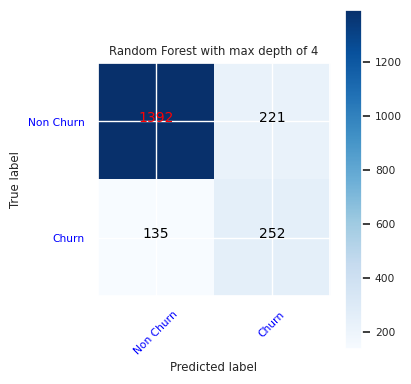

In [30]:
cfm = confusion_matrix(y_test, y_pred=ypred_rfc1_sm)
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='Random Forest with max depth of 4')
tn, fp, fn, tp = cfm.ravel()

Create a confusion matrix for Random Forest Classifier with maximum depth of eight, with six features.

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 39, Finished, Available)

[[1451  162]
 [ 144  243]]


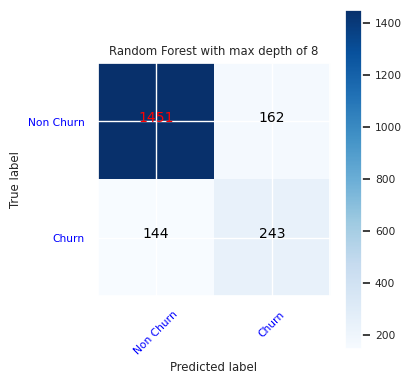

In [31]:
cfm = confusion_matrix(y_test, y_pred=ypred_rfc2_sm)
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='Random Forest with max depth of 8')
tn, fp, fn, tp = cfm.ravel()

Create the confusion matrix for LightGBM.

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 40, Finished, Available)

[[1494  119]
 [ 146  241]]


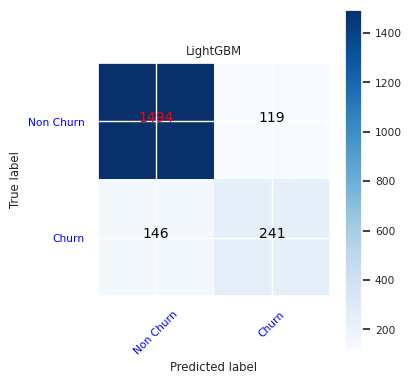

In [32]:
cfm = confusion_matrix(y_test, y_pred=ypred_lgbm1_sm)
plot_confusion_matrix(cfm, classes=['Non Churn','Churn'],
                      title='LightGBM')
tn, fp, fn, tp = cfm.ravel()

### Save results for Power BI

Move model prediction results to Power BI Visualization by saving delta frame to lakehouse.

In [33]:
df_pred = X_test.copy()
df_pred['y_test'] = y_test
df_pred['ypred_rfc1_sm'] = ypred_rfc1_sm
df_pred['ypred_rfc2_sm'] =ypred_rfc2_sm
df_pred['ypred_lgbm1_sm'] = ypred_lgbm1_sm
table_name = "df_pred_results"
sparkDF=spark.createDataFrame(df_pred)
sparkDF.write.mode("overwrite").format("delta").option("overwriteSchema", "true").save(f"Tables/{table_name}")
print(f"Spark dataframe saved to delta table: {table_name}")

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 41, Finished, Available)

Spark dataframe saved to delta table: df_pred_results


## Step 6: Business Intelligence via Visualizations in Power BI

Use these steps to access your saved table in Power BI.

1. On the left, select **OneLake data hub**.
1. Select the lakehouse that you added to this notebook.
1. On the top right, select **Open** under the section titled **Open this Lakehouse**.
1. Select New Power BI dataset on the top ribbon and select `df_pred_results`, then select **Continue** to create a new Power BI dataset linked to the predictions.
1. On the tools at the top of the dataset page, select **New report** to open the Power BI report authoring page.

Some example visualizations are shown here. The data panel shows the delta tables and columns from the table to select. Upon selecting appropriate x and y axes, you can pick the filters and functions, for example, sum or average of the table column.

> [!NOTE]
> This shows an illustrated example of how you would analyze the saved prediction results in Power BI. However, for a real customer churn use-case, the platform user may have to do more thorough ideation of what visualizations to create, based on subject matter expertise, and what their firm and business analytics team has standardized as metrics.

<img src="https://synapseaisolutionsa.blob.core.windows.net/public/bankcustomerchurn/PBIviz3.png"  width="100%" height="100%" title="Screenshot shows a Power BI dashboard example.">

The Power BI report shows that customers who use more than two of the bank products have a higher churn rate although few customers had more than two products. The bank should collect more data, but also investigate other features correlated with more products (see the plot in the bottom left panel).
Bank customers in Germany have a higher churn rate than in France and Spain (see the plot in the bottom right panel), which suggests that an investigation into what has encouraged customers to leave could be beneficial.
There are more middle aged customers (between 25-45) and customers between 45-60 tend to exit more.
Finally, customers with lower credit scores would most likely leave the bank for other financial institutes. The bank should look into ways that encourage customers with lower credit scores and account balances to stay with the bank.

In [34]:
# Determine the entire runtime
print(f"Full run cost {int(time.time() - ts)} seconds.")

StatementMeta(, 40d6c1bd-7de1-466d-9250-6fa21f5a2964, 42, Finished, Available)

Full run cost 100 seconds.
